In [2]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import os

# Spectrum Bounds Analysis

In [19]:
dataset = "mnist"
model = "mlp"
proj_type = "normal"
n_samples = 1000
hold_out = False  # Set to True to load results from --hold_out runs

holdout_suffix = "_holdout" if hold_out else ""
results_path = f"./results/spectrum_bounds/{dataset}_{model}_{proj_type}_n{n_samples}{holdout_suffix}.pt"

if not os.path.exists(results_path):
    print(f"Error: File not found at {results_path}")
else:
    results = torch.load(results_path, map_location="cpu", weights_only=False)

    print(f"Loaded results for {results.get('model', 'unknown')} on {results.get('dataset', 'unknown')}")
    print(f"Projection: {results.get('proj_type', 'unknown')}")
    print(f"Samples: {results.get('n_samples', '?')}, Params: {results.get('d_params', '?')}")
    print(f"Hold out gradients: {results.get('use_held_out_gradients', False)}")

Loaded results for mlp on mnist
Projection: normal
Samples: 1000, Params: 109386
Hold out gradients: False


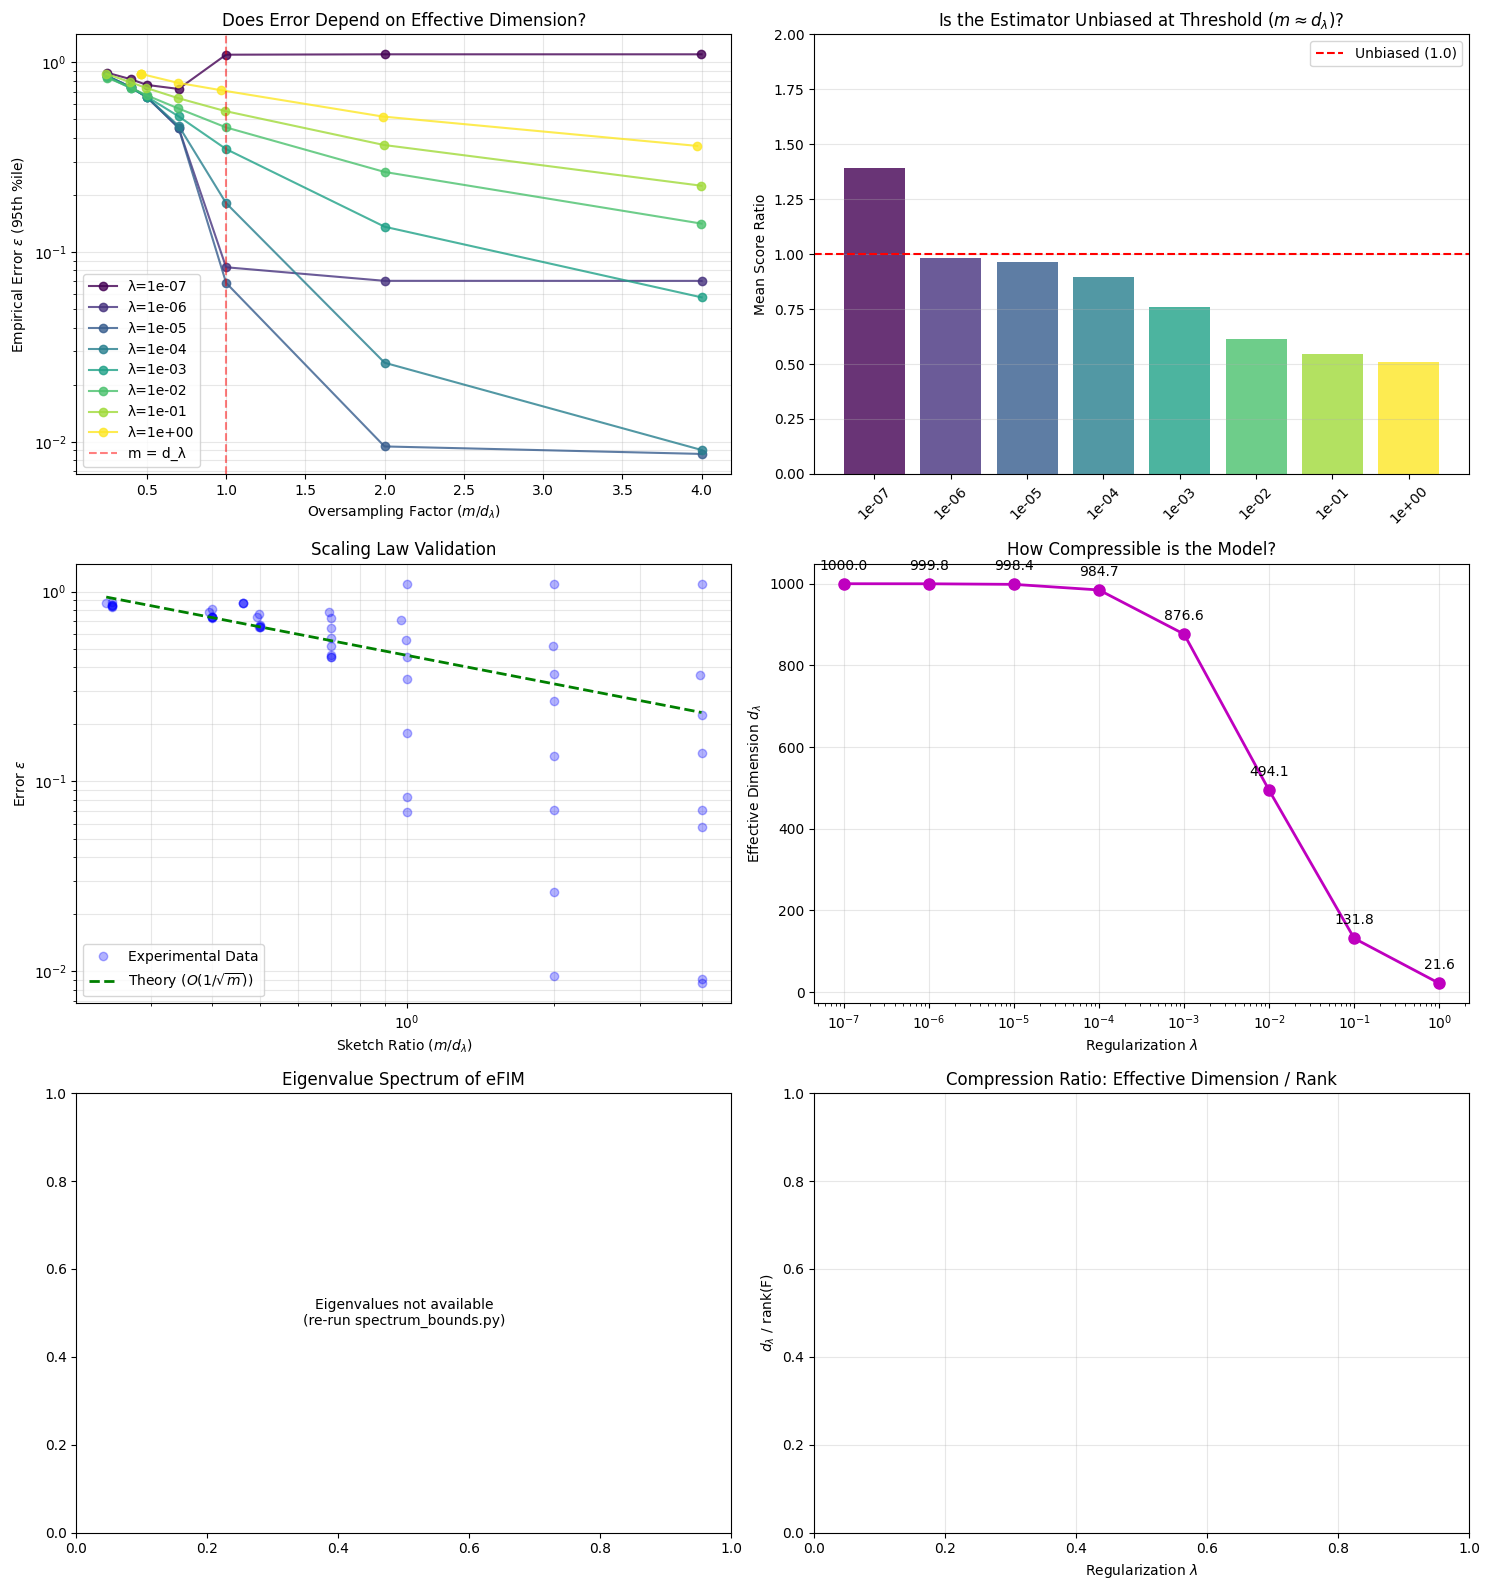

In [20]:
# ==========================================
# 2. Plotting Logic
# ==========================================
def plot_spectrum_bounds(results):
    experiments = results["experiments"]
    lambda_values = results["lambda_values"]

    # Organize data by lambda for easier plotting
    by_lambda = {}
    for exp in experiments:
        lamb = exp["lambda"]
        if lamb not in by_lambda:
            by_lambda[lamb] = []
        by_lambda[lamb].append(exp)

    # Setup the figure (3x2 grid to include eigenvalue spectrum)
    fig, axes = plt.subplots(3, 2, figsize=(15, 16))
    colors = plt.cm.viridis(np.linspace(0, 1, len(lambda_values)))

    # -------------------------------------------------------
    # Plot 1: Approximation Error vs. Sketch Ratio (m / d_lambda)
    # -------------------------------------------------------
    ax1 = axes[0, 0]
    for i, lamb in enumerate(lambda_values):
        if lamb not in by_lambda: continue

        # Sort by m/d_lambda so the line connects properly
        exps = sorted(by_lambda[lamb], key=lambda x: x["m_over_d_lambda"])

        x = [e["m_over_d_lambda"] for e in exps]
        y = [e["empirical_eps_95"] for e in exps]

        ax1.semilogy(x, y, 'o-', color=colors[i], label=f'λ={lamb:.0e}', markersize=6, alpha=0.8)

    ax1.axvline(x=1.0, color='red', linestyle='--', alpha=0.5, label='m = d_λ')
    ax1.set_xlabel('Oversampling Factor ($m / d_\lambda$)')
    ax1.set_ylabel('Empirical Error $\epsilon$ (95th %ile)')
    ax1.set_title('Does Error Depend on Effective Dimension?')
    ax1.legend()
    ax1.grid(True, alpha=0.3, which="both")

    # -------------------------------------------------------
    # Plot 2: Bias Check (Score Ratio at m ≈ d_lambda)
    # -------------------------------------------------------
    ax2 = axes[0, 1]
    ratios_at_one = []
    valid_lambdas = []

    for lamb in lambda_values:
        if lamb not in by_lambda: continue
        exps = by_lambda[lamb]

        # Find the experiment closest to m = d_lambda (ratio = 1.0)
        closest = min(exps, key=lambda x: abs(x["m_over_d_lambda"] - 1))
        ratios_at_one.append(closest["mean_ratio"])
        valid_lambdas.append(lamb)

    ax2.bar(range(len(valid_lambdas)), ratios_at_one, color=colors[:len(valid_lambdas)], alpha=0.8)
    ax2.axhline(y=1.0, color='red', linestyle='--', label='Unbiased (1.0)')

    ax2.set_xticks(range(len(valid_lambdas)))
    ax2.set_xticklabels([f'{l:.0e}' for l in valid_lambdas], rotation=45)
    ax2.set_ylim(0.0, 2.0) # Cap y-axis to see deviations clearly
    ax2.set_ylabel('Mean Score Ratio')
    ax2.set_title('Is the Estimator Unbiased at Threshold ($m \\approx d_\lambda$)?')
    ax2.legend()
    ax2.grid(True, axis='y', alpha=0.3)

    # -------------------------------------------------------
    # Plot 3: Scaling Law Validation (Log-Log)
    # -------------------------------------------------------
    ax3 = axes[1, 0]

    all_m_ratio = np.array([e["m_over_d_lambda"] for e in experiments])
    all_eps = np.array([e["empirical_eps_95"] for e in experiments])

    # Filter out Infs or NaNs
    mask = np.isfinite(all_m_ratio) & np.isfinite(all_eps) & (all_m_ratio > 0) & (all_eps > 0)
    x_clean = all_m_ratio[mask]
    y_clean = all_eps[mask]

    ax3.loglog(x_clean, y_clean, 'bo', alpha=0.3, label='Experimental Data')

    # Theoretical Reference Line: epsilon = C / sqrt(m/d_lambda)
    # We anchor the line to the median point of the data
    if len(x_clean) > 0:
        x_theory = np.logspace(np.log10(x_clean.min()), np.log10(x_clean.max()), 100)
        # C = median(y * sqrt(x))
        C = np.median(y_clean * np.sqrt(x_clean))
        y_theory = C / np.sqrt(x_theory)

        ax3.loglog(x_theory, y_theory, 'g--', linewidth=2, label=r'Theory ($O(1/\sqrt{m})$)')

    ax3.set_xlabel('Sketch Ratio ($m / d_\lambda$)')
    ax3.set_ylabel('Error $\epsilon$')
    ax3.set_title('Scaling Law Validation')
    ax3.legend()
    ax3.grid(True, alpha=0.3, which="both")

    # -------------------------------------------------------
    # Plot 4: Effective Dimension vs. Regularization
    # -------------------------------------------------------
    ax4 = axes[1, 1]

    # Extract d_lambda values from the stored dictionary
    eff_dims = results.get("effective_dims", {})
    if eff_dims:
        d_vals = [eff_dims[l] for l in lambda_values if l in eff_dims]
        l_vals = [l for l in lambda_values if l in eff_dims]

        ax4.semilogx(l_vals, d_vals, 'mo-', markersize=8, linewidth=2)

        # Add labels for specific values
        for l, d in zip(l_vals, d_vals):
            ax4.annotate(f'{d:.1f}', (l, d), textcoords="offset points", xytext=(0,10), ha='center')

    ax4.set_xlabel('Regularization $\lambda$')
    ax4.set_ylabel('Effective Dimension $d_\lambda$')
    ax4.set_title('How Compressible is the Model?')
    ax4.grid(True, alpha=0.3)

    # -------------------------------------------------------
    # Plot 5: Eigenvalue Spectrum (log scale)
    # -------------------------------------------------------
    ax5 = axes[2, 0]
    eigenvalues = results.get("eigenvalues")
    rank = results.get("rank", len(eigenvalues) if eigenvalues is not None else 0)

    if eigenvalues is not None:
        ax5.semilogy(eigenvalues[:rank], 'b-', linewidth=1.5)
        ax5.set_xlabel('Index i')
        ax5.set_ylabel('Eigenvalue λ_i')
        ax5.set_title(f'Eigenvalue Spectrum of eFIM (rank={rank})')
        ax5.grid(True, alpha=0.3)

        # Add decay rate annotation
        if rank > 10:
            log_idx = np.log(np.arange(1, min(rank, 100) + 1))
            log_eig = np.log(eigenvalues[:min(rank, 100)] + 1e-15)
            slope, _ = np.polyfit(log_idx, log_eig, 1)
            ax5.annotate(f'Decay rate ≈ i^{slope:.2f}', xy=(0.6, 0.9),
                        xycoords='axes fraction', fontsize=10)
    else:
        ax5.text(0.5, 0.5, 'Eigenvalues not available\n(re-run spectrum_bounds.py)',
                ha='center', va='center', transform=ax5.transAxes)
        ax5.set_title('Eigenvalue Spectrum of eFIM')

    # -------------------------------------------------------
    # Plot 6: d_λ / rank ratio (compression potential)
    # -------------------------------------------------------
    ax6 = axes[2, 1]
    if eff_dims and rank > 0:
        ratios = [d / rank for d in d_vals]
        ax6.semilogx(l_vals, ratios, 'co-', markersize=8, linewidth=2)
        ax6.axhline(y=1.0, color='r', linestyle='--', alpha=0.7, label='No compression')
        ax6.axhline(y=0.5, color='g', linestyle='--', alpha=0.7, label='50% compression')
        ax6.set_ylim([0, 1.1])
        ax6.legend()
    ax6.set_xlabel('Regularization $\lambda$')
    ax6.set_ylabel('$d_\lambda$ / rank(F)')
    ax6.set_title('Compression Ratio: Effective Dimension / Rank')
    ax6.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

# Run the function
if 'results' in locals():
    plot_spectrum_bounds(results)

# Hyperparameter Selection Comparison

In [34]:
# Load hyperparameter comparison results
dataset = "cifar2"
model = "resnet9"
hyperparam_results_path = f"./results/hyperparam_selection/{dataset}_{model}_full.pt"

if not os.path.exists(hyperparam_results_path):
    print(f"Error: File not found at {hyperparam_results_path}")
    hyperparam_results = None
else:
    hyperparam_results = torch.load(hyperparam_results_path, map_location="cpu", weights_only=False)
    print(f"Loaded hyperparameter comparison results")
    print(f"Dataset: {hyperparam_results.get('dataset', '?')}, Model: {hyperparam_results.get('model', '?')}")

Loaded hyperparameter comparison results
Dataset: cifar2, Model: resnet9


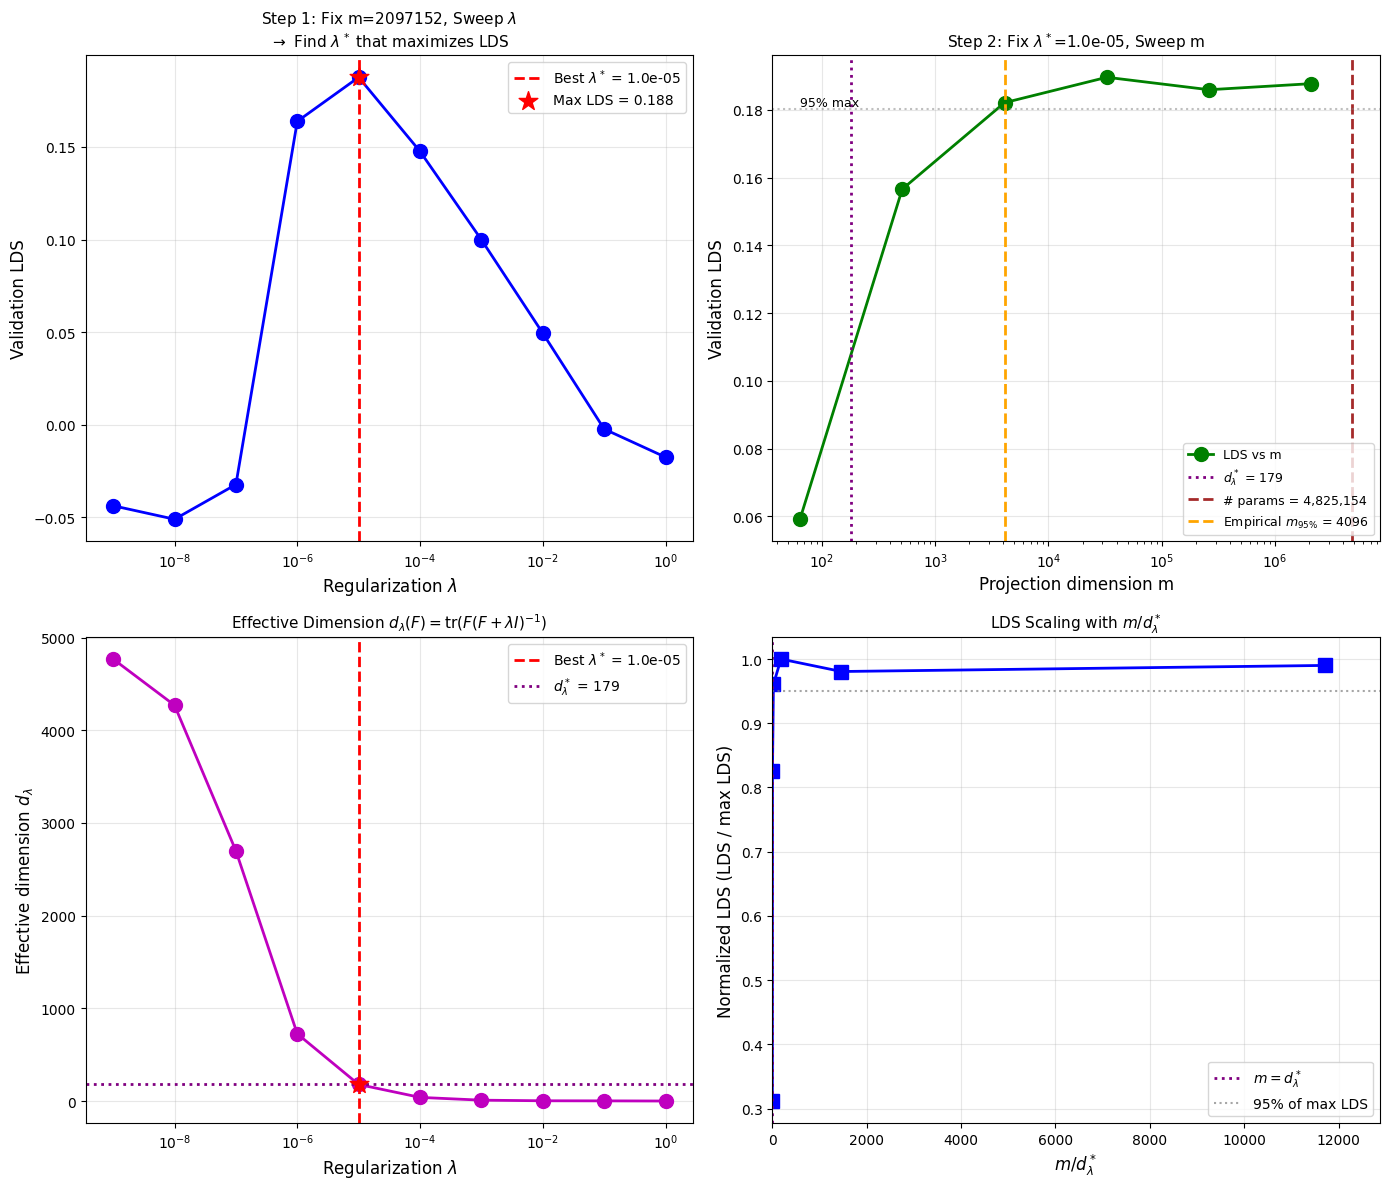

In [35]:
def plot_comparison_results(results: dict):
    """
    Plot comparison of hyperparameter selection approaches.

    Key insight to demonstrate:
    - Sequential approach: Fix m large -> find lambda* -> study how LDS varies with m
    """
    fig, axes = plt.subplots(2, 2, figsize=(14, 12))

    best_lambda = results["lambda_sweep"]["best_lambda"]
    d_lambda_star = results["d_lambda"].get(
        best_lambda,
        results["d_lambda"][min(results["d_lambda"].keys(), key=lambda x: abs(x - best_lambda))]
    )
    n_params = results.get("n_params", None)

    # =========================================================================
    # Plot 1: Step 1 of Sequential Approach - Fix m, sweep lambda
    # =========================================================================
    ax1 = axes[0, 0]
    lambda_vals = results["lambda_sweep"]["lambda_values"]
    val_lds = results["lambda_sweep"]["val_lds"]

    ax1.semilogx(lambda_vals, val_lds, 'bo-', markersize=10, linewidth=2)
    ax1.axvline(x=best_lambda, color='r', linestyle='--', linewidth=2,
                label=f'Best $\\lambda^*$ = {best_lambda:.1e}')

    # Mark the best point
    best_idx = lambda_vals.index(best_lambda) if best_lambda in lambda_vals else \
               val_lds.index(max(val_lds))
    ax1.scatter([lambda_vals[best_idx]], [val_lds[best_idx]], s=200, c='red',
                marker='*', zorder=5, label=f'Max LDS = {val_lds[best_idx]:.3f}')

    ax1.set_xlabel('Regularization $\\lambda$', fontsize=12)
    ax1.set_ylabel('Validation LDS', fontsize=12)
    ax1.set_title(f'Step 1: Fix m={results["lambda_sweep"]["proj_dim"]}, Sweep $\\lambda$\n'
                  f'$\\rightarrow$ Find $\\lambda^*$ that maximizes LDS',
                  fontsize=11)
    ax1.legend(loc='best')
    ax1.grid(True, alpha=0.3)

    # =========================================================================
    # Plot 2: Step 2 of Sequential Approach - Fix lambda*, sweep m
    # =========================================================================
    ax2 = axes[0, 1]
    m_vals = results["m_sweep"]["m_values"]
    m_lds = results["m_sweep"]["val_lds"]

    ax2.semilogx(m_vals, m_lds, 'go-', markersize=10, linewidth=2, label='LDS vs m')

    # Mark d_lambda* as reference (without claiming it's a threshold)
    ax2.axvline(x=d_lambda_star, color='purple', linestyle=':', linewidth=2,
                label=f'$d_\\lambda^*$ = {d_lambda_star:.0f}')

    # Mark parameter count on the m-axis
    if n_params is not None:
        ax2.axvline(x=n_params, color='brown', linestyle='--', linewidth=2,
                    label=f'# params = {n_params:,}')

    # Find empirical threshold: where LDS reaches 95% of max
    max_lds = max(m_lds)
    threshold_95 = 0.95 * max_lds
    empirical_min_m = None
    for m, lds_val in zip(m_vals, m_lds):
        if lds_val >= threshold_95:
            empirical_min_m = m
            break

    if empirical_min_m:
        ax2.axvline(x=empirical_min_m, color='orange', linestyle='--',  linewidth=2,
                    label=f'Empirical $m_{{95\\%}}$ = {empirical_min_m}')

    ax2.axhline(y=threshold_95, color='gray', linestyle=':', alpha=0.5)
    ax2.text(min(m_vals), threshold_95, '95% max', fontsize=9, va='bottom')

    ax2.set_xlabel('Projection dimension m', fontsize=12)
    ax2.set_ylabel('Validation LDS', fontsize=12)
    ax2.set_title(f'Step 2: Fix $\\lambda^*$={best_lambda:.1e}, Sweep m',
                  fontsize=11)
    ax2.legend(loc='lower right', fontsize=9)
    ax2.grid(True, alpha=0.3)

    # =========================================================================
    # Plot 3: Effective Dimension vs lambda
    # =========================================================================
    ax3 = axes[1, 0]
    d_lambda_dict = results["d_lambda"]
    lambdas = sorted(d_lambda_dict.keys())
    d_lambdas = [d_lambda_dict[l] for l in lambdas]

    ax3.semilogx(lambdas, d_lambdas, 'mo-', markersize=10, linewidth=2)
    ax3.axvline(x=best_lambda, color='r', linestyle='--', linewidth=2,
                label=f'Best $\\lambda^*$ = {best_lambda:.1e}')
    ax3.axhline(y=d_lambda_star, color='purple', linestyle=':', linewidth=2,
                label=f'$d_\\lambda^*$ = {d_lambda_star:.0f}')

    # Annotate the key point
    ax3.scatter([best_lambda], [d_lambda_star], s=200, c='red', marker='*', zorder=5)

    ax3.set_xlabel('Regularization $\\lambda$', fontsize=12)
    ax3.set_ylabel('Effective dimension $d_\\lambda$', fontsize=12)
    ax3.set_title('Effective Dimension $d_\\lambda(F) = \\mathrm{tr}(F(F+\\lambda I)^{-1})$', fontsize=11)
    ax3.legend(loc='best')
    ax3.grid(True, alpha=0.3)

    # =========================================================================
    # Plot 4: LDS vs m/d_lambda* (scaling behavior)
    # =========================================================================
    ax4 = axes[1, 1]

    # Normalize LDS to show relative performance
    normalized_lds = [(lds / max_lds) for lds in m_lds]
    m_over_d = [m / d_lambda_star for m in m_vals]

    ax4.plot(m_over_d, normalized_lds, 'bs-', markersize=10, linewidth=2)
    ax4.axvline(x=1.0, color='purple', linestyle=':', linewidth=2,
                label='$m = d_\\lambda^*$')
    ax4.axhline(y=0.95, color='gray', linestyle=':', alpha=0.7, label='95% of max LDS')

    ax4.set_xlabel('$m / d_\\lambda^*$', fontsize=12)
    ax4.set_ylabel('Normalized LDS (LDS / max LDS)', fontsize=12)
    ax4.set_title('LDS Scaling with $m / d_\\lambda^*$', fontsize=11)
    ax4.legend(loc='lower right')
    ax4.grid(True, alpha=0.3)
    ax4.set_xlim([0, max(m_over_d) * 1.1])

    plt.tight_layout()
    plt.show()


# Run the function
if hyperparam_results is not None:
    plot_comparison_results(hyperparam_results)